# Imports

In [1]:
##########
# basics #
##########

import warnings
warnings.filterwarnings('ignore')
import collections
import datetime
import glob
import hashlib
import itertools
import math
import operator
import os
import pickle
import random
import re
import string
import sys
import time

###########
# science #
###########

import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
rseed = random.seed(42)
np.random.seed(rseed)

######
# ml #
######

import theano as thno
import keras as krs
import tensorflow as tf

###################
# sklearn tooling #
###################

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks as cf
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))
cf.set_config_file(offline=False, world_readable=False, theme='pearl')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
mpl.rcParams['figure.figsize']=(12.0,4.0)
%matplotlib inline

############
# sys info #
############

%reload_ext watermark
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,pandas,sklearn,theano,keras,tensorflow,\
matplotlib,seaborn,plotly

Using TensorFlow backend.
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Ken Cavagnolo 
last updated: Mon Nov 14 2016 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.2
scipy 0.18.1
pandas 0.19.0
sklearn 0.18
theano 0.8.2
keras 1.1.0
tensorflow 0.10.0rc0
matplotlib 1.5.3
seaborn 0.7.1
plotly 1.12.9

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : ubuntu
Git hash   : c83f3eb6232595fc8a361a97445f387733bad523


# Functions

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path, header=None, names=column_names)
    return data

def mad_reject(y, thresh=3.5):
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

# Data

Data [here](http://www.cis.fordham.edu/wisdm/dataset.php#activityprediction)

In [3]:
dataset = read_data('data/actitracker_raw.txt')

In [24]:
dataset.describe()

,user-id,x-axis,y-axis,z-axis
count,3.005411e+06,2.980765e+06,2.980765e+06,2.980765e+06
mean,1.021751e+03,4.844853e+10,-1.373680e+05,1.984417e+14
std,4.897168e+02,8.364586e+13,2.371697e+08,3.426074e+17
min,1.940000e+02,-4.628739e+01,-4.094710e+11,-4.820949e+01
25%,6.300000e+02,-2.230362e+00,-2.700000e-01,-1.225831e+00
50%,7.030000e+02,-2.130529e-03,1.650000e+00,1.160644e-02
75%,1.603000e+03,2.508824e+00,8.850000e+00,2.476410e+00
max,1.802000e+03,1.444137e+17,8.013994e+01,5.915081e+20


In [25]:
dataset.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,1679,Walking,1370520469556,0.294132,-0.635605,-0.226936
1,1679,Walking,1370520469606,-0.499688,-0.604451,-0.226020
2,1679,Walking,1370520469656,-2.178345,0.713491,0.372017
3,1679,Walking,1370520469706,-2.797763,1.354899,-0.277638
4,1679,Walking,1370520469756,-2.167961,-1.327716,-0.554971


In [5]:
dataset['z-axis'] = dataset['z-axis'].map(lambda x: float(str(x).replace(';','')))

In [26]:
mad_reject(dataset['z-axis']).describe()

count     3005411
unique          1
top         False
freq      3005411
Name: z-axis, dtype: object

In [28]:
dataset = dataset[dataset['z-axis'] < 100]

In [29]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])

In [30]:
dataset['y-axis'] = feature_normalize(dataset['y-axis'])

In [31]:
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

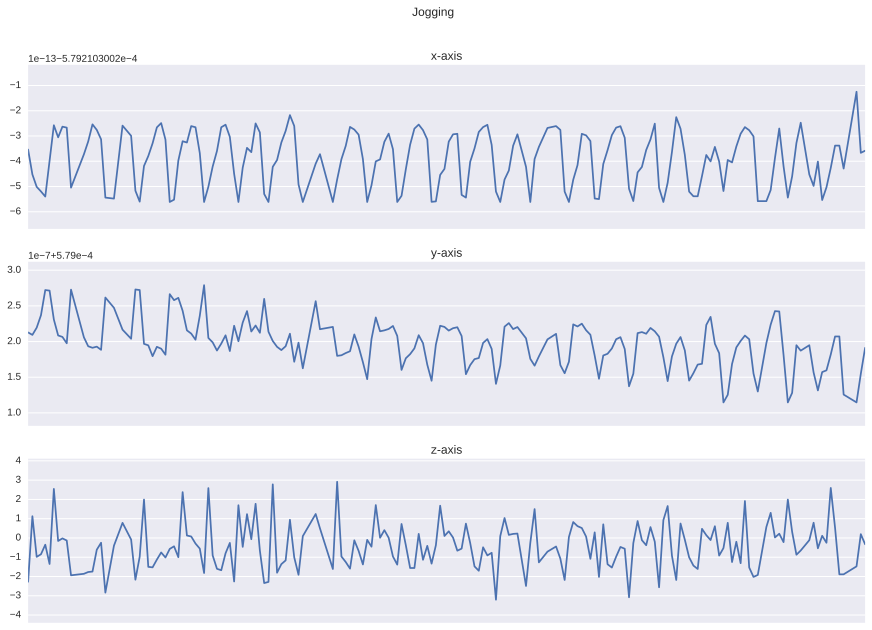

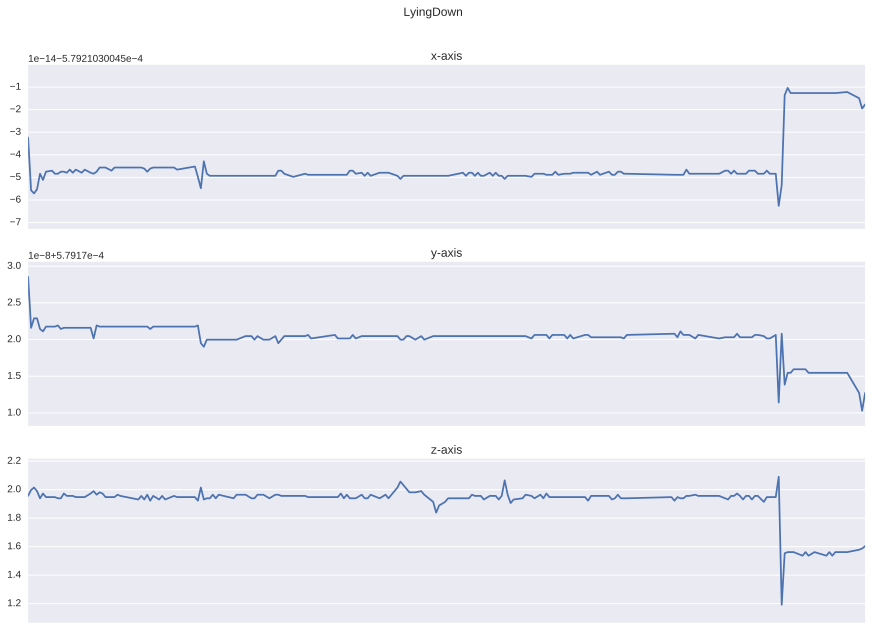

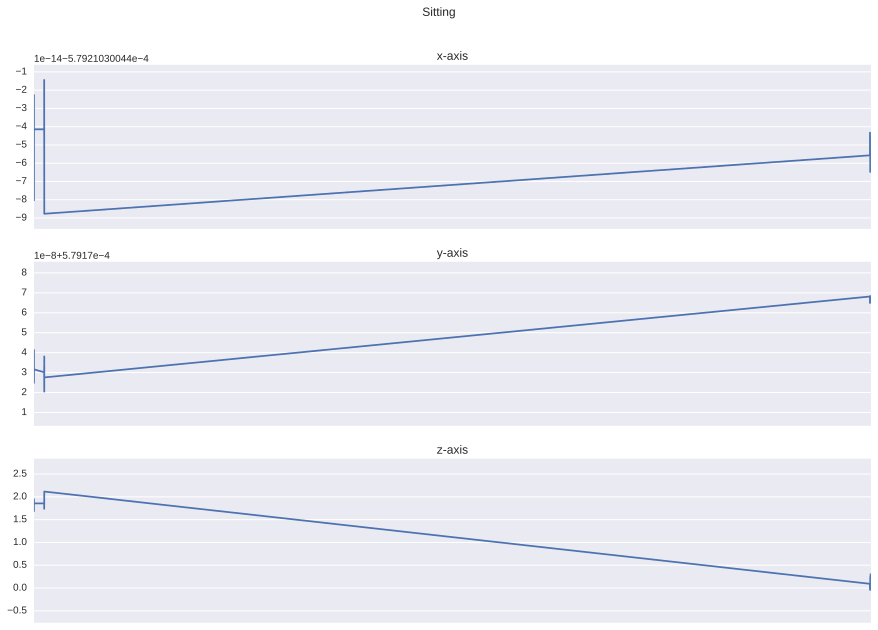

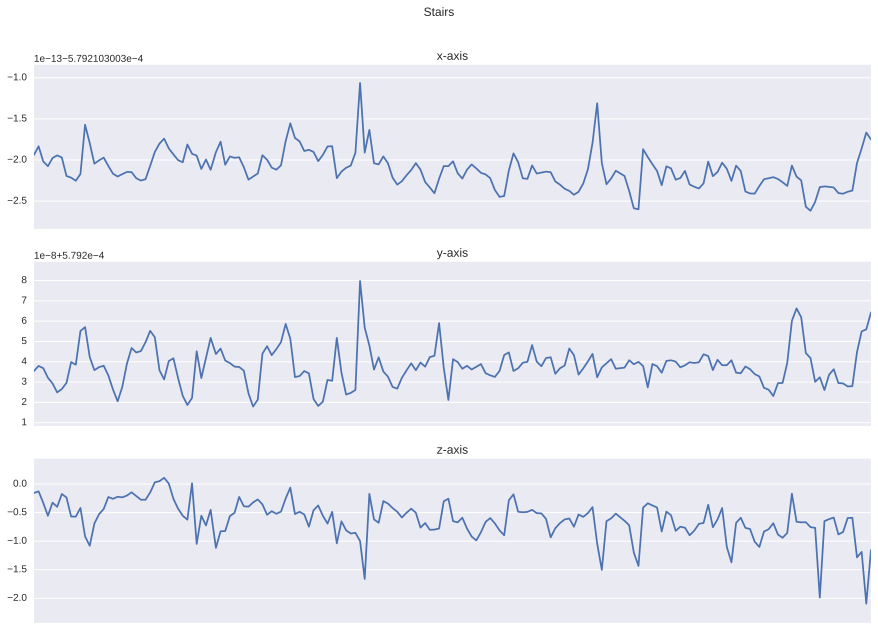

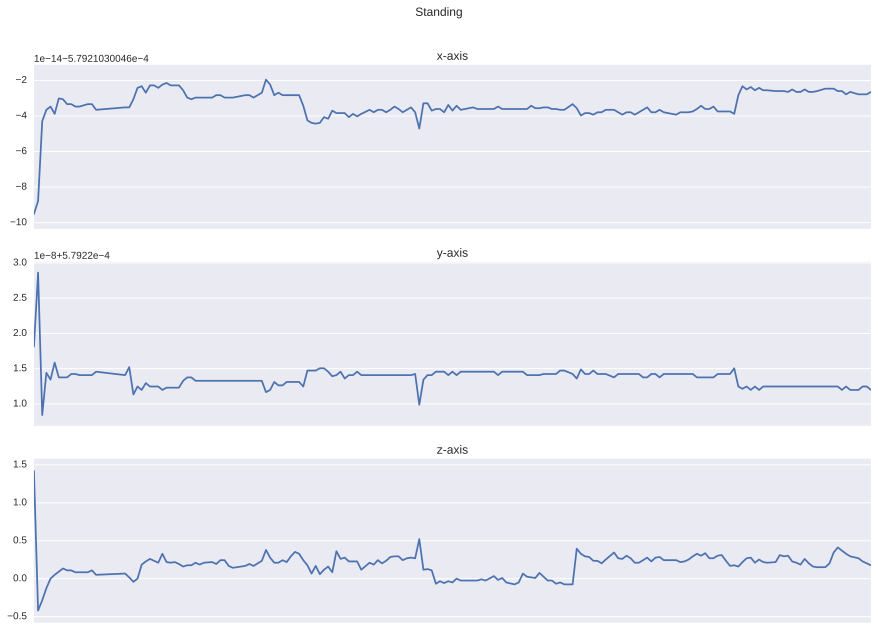

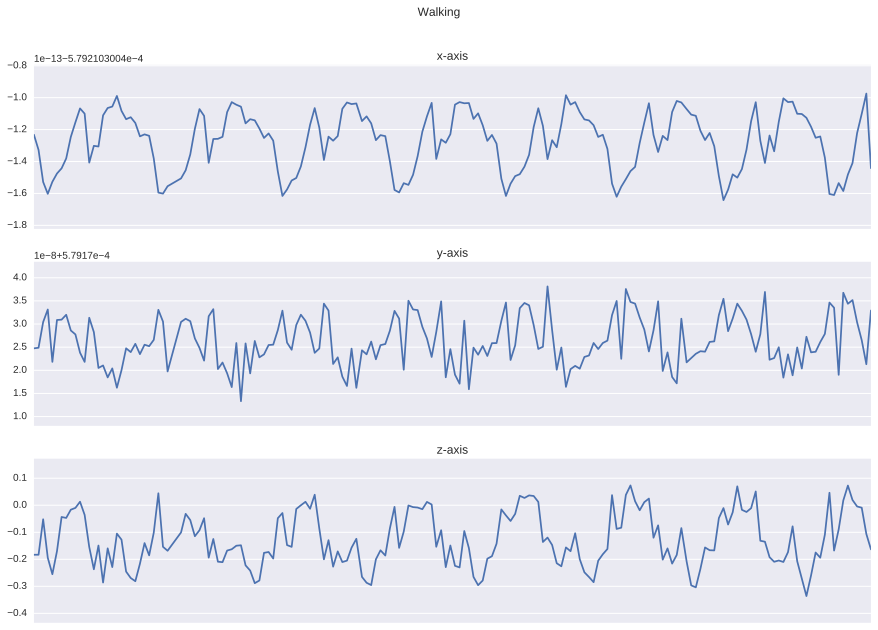

In [32]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

In [ ]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [ ]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [12]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 8

total_batchs = reshaped_segments.shape[0] // batch_size

In [14]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [ ]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
cost_history = np.empty(shape=[1],dtype=float)

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch in range(training_epochs):
        for b in range(total_batchs):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print "Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y})
    
    print "Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y})